In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import bicgstab
import Reader as rd
from glob import glob
import matplotlib.patches as patches
import pandas as pd
import math
from scipy.misc import imread


import os

In [2]:
def e_neighbour_graph(img, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            result[row * colN + col][(row + rowDiff) * colN + (col + colDiff)] = 1
    return result


def fully_connected_graph(img, sigma):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for row2 in range(rowN):
                for col2 in range(colN):
                    weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                    result[row * colN + col][row2 * colN + col2] = weight
    return result


def fully_connected_e_neighbour_graph(img, sigma, e):
    array = np.array(img)
    rowN = np.shape(array)[0]
    colN = np.shape(array)[1]
    result = np.zeros((rowN * colN, rowN * colN))
    for row in range(rowN):
        for col in range(colN):
            for rowDiff in range(-e, e + 1, 1):
                for colDiff in range(-e, e + 1, 1):
                    if(row + rowDiff < rowN and -1 < row + rowDiff and col + colDiff < colN and -1 < col + colDiff):
                        if(rowDiff * rowDiff + colDiff * colDiff <= e * e):
                            row2 = row + rowDiff
                            col2 = col + colDiff
                            weight = math.exp(- math.pow(img[row][col] - img[row2][col2], 2) / (2 * math.pow(sigma, 2)))
                            result[row * colN + col][row2 * colN + col2] = weight
    return result
'''
# Check for graph implementations
ANGLE = 0 # 0-15, 0 is front, 8 is back
path_list = glob("./stage1_aps/*.aps")
path = path_list[0]
data = rd.read_data(path_list[0])
# we only get images from one certain angle
# img = np.rot90(data[:,:, ANGLE])
# imgplt = plt.imshow(img)
plt.show()


img2 = imread("./sample.jpg")
img2 = np.asarray(img2,np.dtype(np.int32))
# plt.imshow(img2)
# plt.show()
A = np.array([[1,2,3], [0,5,6]])
# A = img2
print("Image")
print(np.shape(A))
print(A)
print("e neighbour graph")
print(e_neighbour_graph(A, 1))
print("Fully connected & e neighbour graph")
print(np.round(fully_connected_e_neighbour_graph(A, 1, 1), decimals=2))
print("Fully connected graph")
print(np.round(fully_connected_graph(A, 1), decimals=2))
'''


def laplacian(graph):
    diag = np.diag(sum(graph))
    lap = diag - graph
    return [lap, diag]


def orthogonalize(diag, s):
    nodeNum = len(diag)
    p = np.ones((nodeNum, 1)) / pow(sum(np.diag(np.diag(sum(diag)))), .5)
    projection = np.dot(np.transpose(s), np.dot(diag, p))
    v = s - projection[0][0] * p
    # return [v, projection]
    return v


def PRwalk(graph, alpha, s):
    if alpha < 0:
        print('Error: alpha must be positive!')
        return -1
    nodeNum = len(graph)
    [L, D] = laplacian(graph)
    s = orthogonalize(D, s)
    v, flag = bicgstab((L + alpha * D), np.dot(D, s),tol=1e-3, maxiter=nodeNum)

    v = np.reshape(v, (len(v), 1))

    v = orthogonalize(D, v)
    return v

# Check for method implementations
# A = np.array([[1, 2, 3], [1, 5, 6]])
# G = np.round(fully_connected_e_neighbour_graph(A, 10, 1), decimals=1)
# print("Laplacian Check")
# [L, D] = laplacian(G)
# print(L)
# print(D)
# print("Orthogonalize check")
# A = np.array([2,3,3])
# D = np.diag(A)
# s = np.array([[1], [2], [3]])
# t = orthogonalize(D, s)
# print(t)
# print("PRwalk check")
# G = np.array([[0, 1], [1, 0]])
# s = np.array([[1], [2]])
# print(PRwalk(G, 1, s)) # output should be [[-0.167], [ 0.167]]

def normalize(D, s):
    norm = np.dot(np.dot(np.transpose(s), D), s)
    v = s/math.sqrt(norm)
    return v


In [52]:
# 1a10297e6c3101af33003e6c4f846f47
IMAGE = "1a10297e6c3101af33003e6c4f846f47"
myImg = np.asarray(imread(IMAGE + "/" + IMAGE + ".aps.jpg"), dtype=np.int)
# print(myImg)
# print(myImg.shape) # 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[40 * myImg.shape[1] + 90][0] = 1 # Example seed
seed[74 * myImg.shape[1] + 88][0] = 1 # Example middle seed
SeedList = [[40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 48):
    for j in range(60, 125, 32):
        SeedList.append([i,j])

In [19]:
# Trying seed as full image
seed = myImg.copy()
seed = seed.reshape(myImg.shape[0] * myImg.shape[1], 1)
# Normalizing seed
seed = seed / math.sqrt(sum(sum(seed * seed)))
[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
exponential = 0
alpha = 2 ** exponential
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
# print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]

print('Threshold: ' + str(1 / len(graph)))
alphaList = []
alphaList.append(alpha)

correlationList = []
correlationList.append(correlation)
      
scoreList = []
scoreList.append(score)

valueList = []
valueList.append(v)
print('')
print('alpha: 2^' + str(exponential))
print('Correlation: ' + str(correlation))
print('Score: ' + str(score))

maxIterations = 29
minIterations = 3
for i in range(maxIterations):
    if correlation > 1 / len(graph):
        oldCorrelation = correlation
        exponential -= 1
        alpha = 2 ** exponential
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        score = ((np.dot(np.dot(np.transpose(v), L), v)) / normalization)[0][0]
        alphaList.append(alpha)
        correlationList.append(correlation)
        scoreList.append(score)
        valueList.append(v)
        print('')
        print('alpha: 2^' + str(exponential))
        print('Correlation: ' + str(correlation))
        print('Score: ' + str(score))
    if i == minIterations:
        print('')
        print('Starting correlation decrease check!')
    if i >= minIterations and oldCorrelation * .99 < correlation:
        break

Threshold: 3.839066339066339e-05

alpha: 2^0
Correlation: 0.999609277212
Score: 0.00284619627768

alpha: 2^-1
Correlation: 0.999100221702
Score: 0.00249159658409

alpha: 2^-2
Correlation: 0.998186253305
Score: 0.00216857517055

alpha: 2^-3
Correlation: 0.996669527778
Score: 0.00189847414363

alpha: 2^-4
Correlation: 0.994198397598
Score: 0.00167644078187

Starting correlation decrease check!


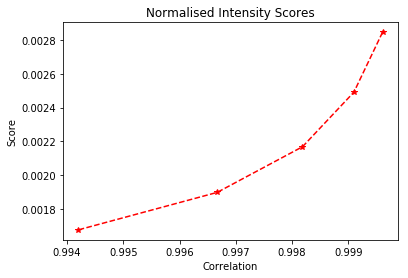

In [49]:
plt.plot(correlationList, scoreList, 'r*--')
plt.xlabel('Correlation')
plt.ylabel('Score')
plt.title('Normalised Intensity Scores')
plt.show()

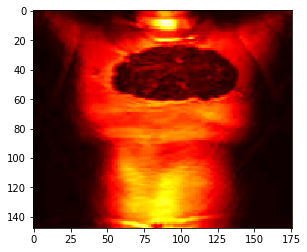

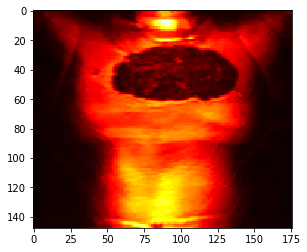

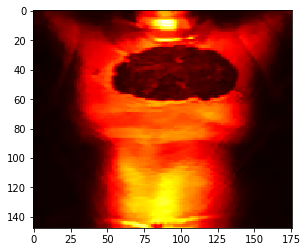

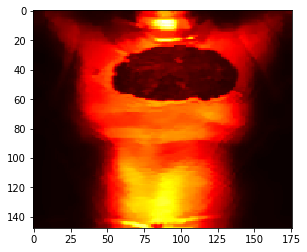

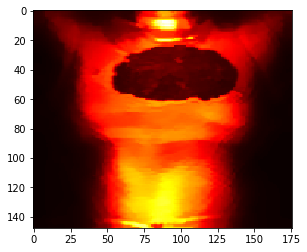

In [87]:
for item in range(len(valueList)):
    heat = np.zeros(myImg.shape)
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            heat[i][j] = valueList[item][i * myImg.shape[1] + j]
    plt.imshow(heat, cmap='hot', interpolation='nearest')
    # plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
    plt.show()

array([-0.01516064, -0.01504589, -0.01486637, ..., -0.01880908,
       -0.01881237, -0.01881528])

In [ ]:
Ps = np.copy(v[:,0])
if(v[point] <= 0):
    print('Negative!')
    Ps = -1 * Ps
for i in range(len(Ps)):
    if(Ps[i] < 0):
        Ps[i] = 0
Ps = Ps / sum(Ps)
# Flattening image
imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        imgArray[i * myImg.shape[1] + j] = myImg[i][j]
LValues = np.argsort(-Ps)
numerator = 0
denominator = 0
for i in range(3500):
    numerator += Ps[LValues[i]] * imgArray[LValues[i]]
    denominator += Ps[LValues[i]]
score = numerator / math.sqrt(denominator)
scoreList.append(score)
print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))

In [ ]:
scoreList = []
for elem in SeedList[0]:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = 10
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    print(correlation)

    while correlation > 1 / len(graph):
        alpha = alpha/2
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        # score these v by the quadratic form of the laplacian and their correlation and then decide which ones to keep
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)
numpySeedList = np.asarray(SeedList)
scoreOverall = []
pointsOverall = []
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))
    pointsOverall.append(copyScoreList[list(argSortList)][i])
    scoreOverall.append([elem[0], elem[1], 1])

0.999640434855
0.998618721697
0.995257055019
0.985341444266
0.960152279998
0.907531413025
0.814664973106
0.679071026739
0.514036600204
0.346753307414
0.20280993974
0.0994691106853
0.0417767551779
0.0167920765851
0.00743927148161


In [5]:
# 0cc6fc725d4b8818415ddc06823fce98
myImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98/0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
seed[70 * myImg.shape[1] + 78][0] = 1 # Example seed
# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed
SeedList = []
for i in range(30, 111, 16):
    for j in range(50, 111, 20):
        SeedList.append([i,j])
scoreList = []
for elem in SeedList:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = .001
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    # print(correlation)

    while correlation < 1 / len(graph):
        alpha = 2 * alpha
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    # print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)
numpySeedList = np.asarray(SeedList)
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))
    pointsOverall.append(copyScoreList[list(argSortList)][i])
    scoreOverall.append([elem[0], elem[1], 2])

(140, 156)
Point: [110, 90] Score: 152.896772214
Point: [110, 70] Score: 149.868111538
Point: [94, 90] Score: 141.653859712
Point: [94, 50] Score: 140.792108337
Point: [94, 70] Score: 140.46532555
Point: [110, 50] Score: 136.274417118
Point: [94, 110] Score: 128.320182021
Point: [110, 110] Score: 125.314297329
Point: [78, 70] Score: 117.8884876
Point: [46, 70] Score: 117.239597281
Point: [30, 70] Score: 116.008172021
Point: [62, 70] Score: 114.797126183
Point: [46, 90] Score: 114.245595076
Point: [30, 90] Score: 111.521018836
Point: [78, 90] Score: 111.443375422
Point: [62, 90] Score: 111.066523328
Point: [46, 50] Score: 104.523121962
Point: [46, 110] Score: 104.283104645
Point: [62, 110] Score: 102.051415894
Point: [62, 50] Score: 97.1582942986
Point: [78, 50] Score: 89.848457236
Point: [78, 110] Score: 85.7691354018
Point: [30, 110] Score: 84.7956813339
Point: [30, 50] Score: 71.892486473


In [8]:
pointsOverall

[94.056283058034168,
 86.831637541840607,
 78.276926224192394,
 78.247805975229781,
 76.087615680475722,
 72.841199380610803,
 71.057359870395217,
 70.914683233100959,
 70.853892357121154,
 68.787719006536435,
 55.802226664234539,
 51.828761284756311,
 50.123825333618406,
 45.86125608047363,
 42.81951174499747,
 21.833959001906724,
 21.472224428726996,
 21.390891073556194,
 21.277633917400983,
 21.197407693776462,
 21.11257017878259,
 20.728240570541782,
 19.908669696916579,
 19.666650455979063,
 152.89677221371866,
 149.86811153815964,
 141.65385971235162,
 140.79210833745898,
 140.46532554988195,
 136.2744171178866,
 128.32018202060593,
 125.31429732870855,
 117.88848760039568,
 117.23959728091964,
 116.00817202071316,
 114.79712618294602,
 114.24559507554318,
 111.52101883556846,
 111.44337542186005,
 111.06652332786176,
 104.52312196164915,
 104.28310464542092,
 102.05141589431582,
 97.158294298567938,
 89.848457236029276,
 85.769135401804789,
 84.795681333940308,
 71.8924864729628

In [15]:
copyScoreList3 = np.copy(pointsOverall)
argSortList = np.argsort(-copyScoreList3)
# copyScoreList3 = (copyScoreList3 - np.mean(copyScoreList3)) / np.std(copyScoreList3)
plt.stem(range(1, len(copyScoreList3) + 1),copyScoreList3[list(argSortList)] , basefmt=" ")
# plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
# plt.savefig('DifferentSeedsPlotNormalized(N(0,1)).eps')
plt.savefig('DifferentSeedsAllPlot.eps')

In [3]:
# '''
myImg = np.asarray(imread("1a10297e6c3101af33003e6c4f846f47/1a10297e6c3101af33003e6c4f846f47.aps.jpg"), dtype=np.int)
# print(myImg)
# print(myImg.shape) # 148 row, 176 columns
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[40 * myImg.shape[1] + 90][0] = 1 # Example seed
seed[74 * myImg.shape[1] + 88][0] = 1 # Example middle seed
'''
myImg = np.asarray(imread("3a8696b99b2d1b28be62389d48d697be/3a8696b99b2d1b28be62389d48d697be.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
# seed[20 * myImg.shape[1] + 65][0] = 1 # Example seed
seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed

myImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)
graph = fully_connected_e_neighbour_graph(myImg, 5, 3)
print(myImg.shape)
# print(np.round(graph, decimals=3))
seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
seed[70 * myImg.shape[1] + 78][0] = 1 # Example seed
# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed
'''

'\nmyImg = np.asarray(imread("3a8696b99b2d1b28be62389d48d697be/3a8696b99b2d1b28be62389d48d697be.aps.jpg"), dtype=np.int)\ngraph = fully_connected_e_neighbour_graph(myImg, 5, 3)\nprint(myImg.shape)\n# print(np.round(graph, decimals=3))\nseed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))\n# seed[20 * myImg.shape[1] + 65][0] = 1 # Example seed\nseed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed\n\nmyImg = np.asarray(imread("0cc6fc725d4b8818415ddc06823fce98.aps.jpg"), dtype=np.int)\ngraph = fully_connected_e_neighbour_graph(myImg, 5, 3)\nprint(myImg.shape)\n# print(np.round(graph, decimals=3))\nseed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))\nseed[70 * myImg.shape[1] + 78][0] = 1 # Example seed\n# seed[70 * myImg.shape[1] + 70][0] = 1 # Example middle seed\n'

In [11]:
SeedList = [[40,90],[40,65],[45,123],[30,100]]
for i in range(25, 122, 24):
    for j in range(60, 125, 21):
        SeedList.append([i,j])
SeedList

[[40, 90],
 [40, 65],
 [45, 123],
 [30, 100],
 [25, 60],
 [25, 81],
 [25, 102],
 [25, 123],
 [49, 60],
 [49, 81],
 [49, 102],
 [49, 123],
 [73, 60],
 [73, 81],
 [73, 102],
 [73, 123],
 [97, 60],
 [97, 81],
 [97, 102],
 [97, 123],
 [121, 60],
 [121, 81],
 [121, 102],
 [121, 123]]

In [90]:
# SeedList = [[25,60],[25,130],[120,60],[120,130]]
# SeedList = [[120,125]]
scoreList = []
for elem in SeedList:
    point = elem[0] * myImg.shape[1] + elem[1]
    seed = np.zeros((myImg.shape[0] * myImg.shape[1], 1))
    seed[point] = 1
    [L, D] = laplacian(graph)
    s = orthogonalize(D, seed)
    s = normalize(D, s)
    alpha = .001
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    # print(normalization)
    correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    # print(correlation)

    while correlation < 1 / len(graph):
        alpha = 2 * alpha
        v = PRwalk(graph, alpha, s)
        normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
        correlation = \
            (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
        print(correlation)
        
    Ps = np.copy(v[:,0])
    if(v[point] <= 0):
        print('Negative!')
        Ps = -1 * Ps
    for i in range(len(Ps)):
        if(Ps[i] < 0):
            Ps[i] = 0
    Ps = Ps / sum(Ps)
    # Flattening image
    imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
    for i in range(myImg.shape[0]):
        for j in range(myImg.shape[1]):
            imgArray[i * myImg.shape[1] + j] = myImg[i][j]
    LValues = np.argsort(-Ps)
    numerator = 0
    denominator = 0
    for i in range(3500):
        numerator += Ps[LValues[i]] * imgArray[LValues[i]]
        denominator += Ps[LValues[i]]
    score = numerator / math.sqrt(denominator)
    scoreList.append(score)
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(score))

KeyboardInterrupt: 

In [40]:
copyScoreList = np.copy(scoreList)
argSortList = np.argsort(-copyScoreList)

In [69]:
plt.stem(range(1, len(copyScoreList) + 1),copyScoreList[list(argSortList)] , basefmt=" ")
plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
plt.savefig('DifferentSeedsPlot.eps')

In [57]:
numpySeedList = np.asarray(SeedList)
for i in range(len(copyScoreList)):
    elem = numpySeedList[list(argSortList)][i]
    print('Point: [' + str(elem[0]) + ', ' + str(elem[1]) + '] Score: ' + str(copyScoreList[list(argSortList)][i]))

Point: [121, 81] Score: 94.056283058
Point: [121, 102] Score: 86.8316375418
Point: [73, 102] Score: 78.2769262242
Point: [73, 81] Score: 78.2478059752
Point: [97, 81] Score: 76.0876156805
Point: [97, 60] Score: 72.8411993806
Point: [121, 60] Score: 71.0573598704
Point: [73, 60] Score: 70.9146832331
Point: [73, 123] Score: 70.8538923571
Point: [97, 102] Score: 68.7877190065
Point: [25, 81] Score: 55.8022266642
Point: [121, 123] Score: 51.8287612848
Point: [25, 60] Score: 50.1238253336
Point: [97, 123] Score: 45.8612560805
Point: [25, 123] Score: 42.819511745
Point: [25, 102] Score: 21.8339590019
Point: [40, 65] Score: 21.4722244287
Point: [30, 100] Score: 21.3908910736
Point: [40, 90] Score: 21.2776339174
Point: [49, 81] Score: 21.1974076938
Point: [49, 60] Score: 21.1125701788
Point: [49, 102] Score: 20.7282405705
Point: [45, 123] Score: 19.9086696969
Point: [49, 123] Score: 19.666650456


In [89]:
copyScoreList2 = np.copy(scoreList)
copyScoreList2 = (copyScoreList2 - np.mean(copyScoreList2)) / np.std(copyScoreList2)
plt.stem(range(1, len(copyScoreList2) + 1),copyScoreList2[list(argSortList)] , basefmt=" ")
# plt.axis([0, 25, 0, 100])
plt.xlabel('Point')
plt.ylabel('Score')
# plt.show()
plt.savefig('DifferentSeedsPlotNormalized(N(0,1)).eps')

In [79]:
[L, D] = laplacian(graph)
s = orthogonalize(D, seed)
s = normalize(D, s)
alpha = .001
v = PRwalk(graph, alpha, s)
normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
print(normalization)
correlation = (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
print(correlation)

while correlation < 1 / len(graph):
    alpha = 2 * alpha
    v = PRwalk(graph, alpha, s)
    normalization = (np.dot(np.dot(np.transpose(v), D), v))[0][0]
    correlation = \
        (np.dot(np.dot(np.dot(np.transpose(v), D), s), np.dot(np.dot(np.transpose(v), D), s)) / normalization)[0][0]
    print(correlation)

109.370271349
0.0235638565228


In [91]:
scoreList

[]

In [87]:
v[74 * myImg.shape[1] + 88]
min(v)

array([-0.00625094])

In [85]:
Ps = np.copy(v[:,0])
for i in range(len(Ps)):
    if(Ps[i] < 0):
        Ps[i] = 0
print(Ps[74 * myImg.shape[1] + 88])
Ps = Ps / sum(Ps)
# Flattening image
imgArray = np.zeros(myImg.shape[0] * myImg.shape[1])
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        imgArray[i * myImg.shape[1] + j] = myImg[i][j]
LValues = np.argsort(-Ps)

0.0
0.380390937484


In [84]:
sum(Ps)

1.0000000000000009

In [75]:
plt.plot(Ps[list(LValues)])
plt.axis([0, 3500, 0, .0005])
# plt.show()
plt.savefig('ScoreCalculation/SeedOutThreadProbabilitySortingZoomed.eps')
# 1a10297e6c3101af33003e6c4f846f47
# L is chosen to be 2500 for seed in  threat
# L is chosen to be 3500 for seed out threat
# 3a8696b99b2d1b28be62389d48d697be
# L is chosen to be 2500 for seed in  threat
# L is chosen to be 3500 for seed out threat

In [86]:
numerator = 0
denominator = 0
for i in range(3500):
    numerator += Ps[LValues[i]] * imgArray[LValues[i]]
    denominator += Ps[LValues[i]]
score = numerator / math.sqrt(denominator)
score
# 1a10297e6c3101af33003e6c4f846f47
# Score for seed in  threat is 20.92396
# Score for seed out threat is 78.89822
# 3a8696b99b2d1b28be62389d48d697be
# Score for seed in  threat is 47.65544
# Score for seed out threat is 96.64295

78.898223757060279

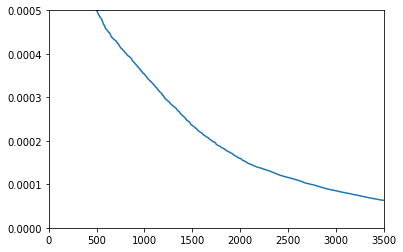

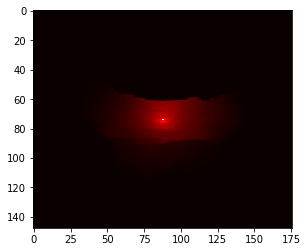

In [47]:
heat = np.zeros(myImg.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[i][j] = Ps[i * myImg.shape[1] + j]
plt.show()
plt.imshow(heat, cmap='hot', interpolation='nearest')
plt.show()

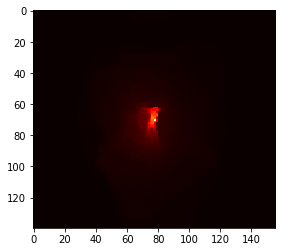

In [122]:
heat = np.zeros(myImg.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[i][j] = v[i * myImg.shape[1] + j]
# plt.show()
# plt.imshow(myImg)
# plt.imshow(heat, cmap='hot', interpolation='nearest')
# plt.imshow(heat, cmap='hot', interpolation='nearest', alpha = .65)
# plt.savefig('0cc6fc725d4b8818415ddc06823fce98/RW_cropped_superimposed_MiddlePointSeed.eps')

(140, 156)
(660, 512)


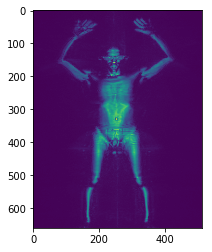

In [124]:
data = rd.read_data("0cc6fc725d4b8818415ddc06823fce98/0cc6fc725d4b8818415ddc06823fce98.aps")
img = np.rot90(data[:, :, 0])
myImgFull = np.asarray(img, dtype=np.double)
heat = np.zeros(myImgFull.shape)
for i in range(myImg.shape[0]):
    for j in range(myImg.shape[1]):
        heat[199 + i][180 + j] = v[i * myImg.shape[1] + j]
print(myImg.shape)
print(heat.shape)
plt.show()
plt.imshow(myImgFull)
# plt.savefig('0cc6fc725d4b8818415ddc06823fce98/FullImage.eps')
plt.imshow(heat, cmap='hot', interpolation='nearest',alpha = .6)
plt.savefig('0cc6fc725d4b8818415ddc06823fce98/RW_FullImage.eps')